<a href="https://colab.research.google.com/github/motazalratta/de-assessments/blob/main/Phase3/notebooks/Transactions_Location_Distribution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Authentication

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from google.colab import auth
from google.cloud.bigquery import magics

magics.context.project = 'analog-patrol-311615'

auth.authenticate_user()
print('Authenticated')

Authenticated


#From which Country are most transactions originating? How many transactions is this?






In [2]:
#@title transaction-level
%%bigquery  countery_max_originating_transaction_level

with originair_distinct as (
  select
    distinct uniqueid,
    originairportcode
  from
    `assessmentdb.transactions`
),
originair_count as (
  select
    originairportcode,
    count(*) transaction_count
  from
    originair_distinct
  group by
    originairportcode
),
origincou_count as (
  select
    loc.countryname,
    sum(transaction_count) transaction_count
  from
    originair_count oac
    inner join  `assessmentdb.locations` loc on oac.originairportcode = loc.airportcode
  group by
    loc.countryname
)
select
  *
from
  origincou_count
ORDER BY
  2 DESC
LIMIT
  20

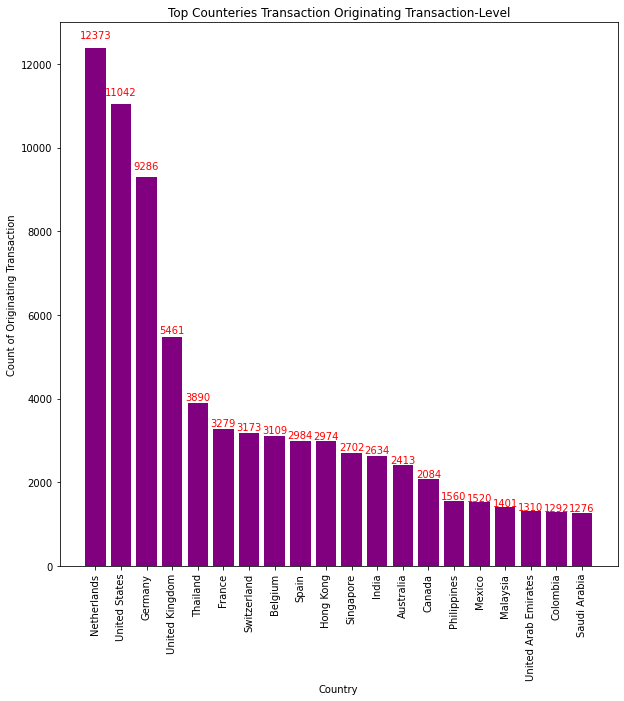

In [3]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.bar(countery_max_originating_transaction_level['countryname'],
       countery_max_originating_transaction_level['transaction_count'],
       color='purple')

for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height}', (x + width/2, y + height*1.02), ha='center',color='red')
    
ax.set(xlabel="Country",
       ylabel="Count of Originating Transaction",
       title="Top Counteries Transaction Originating Transaction-Level")
plt.setp(ax.get_xticklabels(), rotation=90)
plt.show()

In [4]:
#@title segment-level
%%bigquery  countery_compare_originating_segment_level

WITH segment_departureair_count AS (
  SELECT
    segment_departureairportcode,
    COUNT(*) transaction_count
  FROM
    `assessmentdb.transactions`
  GROUP BY
    segment_departureairportcode
),
origincou_count AS (
  SELECT
    loc.countryname,
    SUM(transaction_count) transaction_count
  FROM
    segment_departureair_count sdac
    INNER JOIN  `assessmentdb.locations` loc ON sdac.segment_departureairportcode = loc.airportcode
  GROUP BY
    loc.countryname
)
SELECT
  *
FROM
  origincou_count 
ORDER BY
  2 DESC
LIMIT
  20

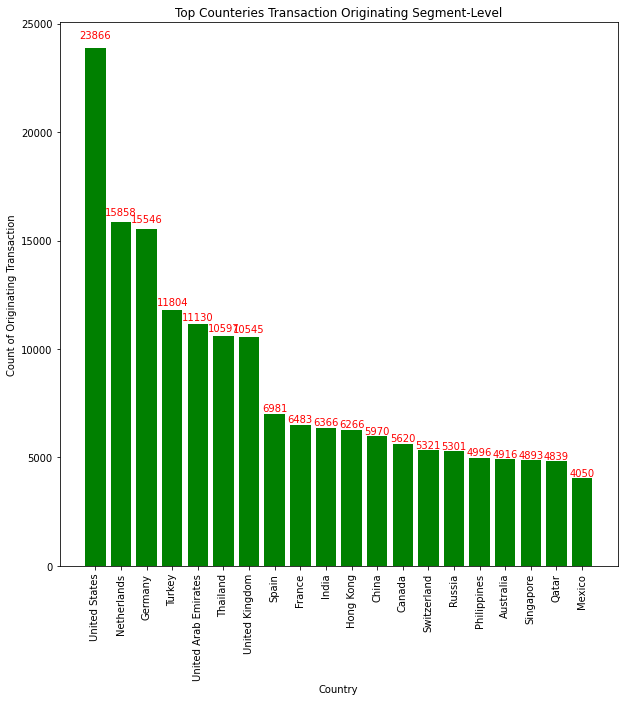

In [5]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.bar(countery_compare_originating_segment_level['countryname'],
        countery_compare_originating_segment_level['transaction_count'],
        color='green')
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height}', (x + width/2, y + height*1.02), ha='center',color='red')
    
ax.set(xlabel="Country",
       ylabel="Count of Originating Transaction",
       title="Top Counteries Transaction Originating Segment-Level")
plt.setp(ax.get_xticklabels(), rotation=90)
plt.show()

# What's the split between domestic vs international transactions?

In [6]:
%%bigquery  domestic_vs_international
WITH
  segmentbased AS (
  SELECT
    source.countryname sourcecountryname,
    target.countryname targetcountryname,
    CASE
      WHEN source.countryname = target.countryname THEN 'domestic'
    ELSE
    'international '
  END
    traveltype
  FROM
    `assessmentdb.transactions` tra
  INNER JOIN
    `assessmentdb.locations` source
  ON
    source.airportcode = tra.segment_departureairportcode
  INNER JOIN
    `assessmentdb.locations` target
  ON
    target.airportcode = tra.segment_arrivalairportcode ),
  distincttransactions AS (
  SELECT
    DISTINCT uniqueid,
    originairportcode,
    destinationairportcode
  FROM
    `assessmentdb.transactions`),

  transactionbased AS (
  SELECT
    source.countryname sourcecountryname,
    target.countryname targetcountryname,
    CASE
      WHEN source.countryname = target.countryname THEN 'domestic'
    ELSE
    'international '
  END
    traveltype
  FROM
    distincttransactions tra
  INNER JOIN
    `assessmentdb.locations` source
  ON
    source.airportcode = tra.originairportcode
  INNER JOIN
    `assessmentdb.locations` target
  ON
    target.airportcode = tra.destinationairportcode )
SELECT
  s.traveltype,
  t.count transactionbasedcount,
  s.count segmentbasedcount
FROM (
  SELECT
    traveltype,
    COUNT(*) count
  FROM
    segmentbased
  GROUP BY
    traveltype) s
INNER JOIN (
  SELECT
    traveltype,
    COUNT(*) count
  FROM
    transactionbased
  GROUP BY
    traveltype) t
ON
  s.traveltype = t.traveltype

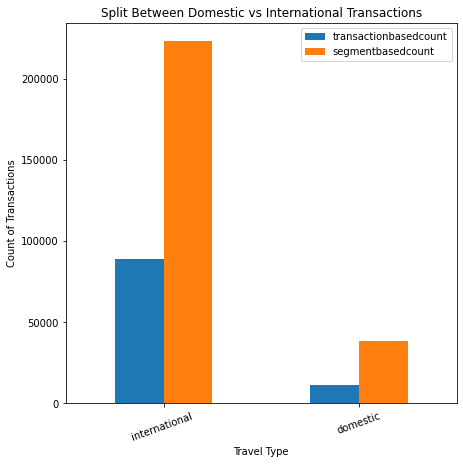

In [7]:
fig, ax = plt.subplots(figsize=(7, 7))
domestic_vs_international.plot.bar(x = 'traveltype', y = ['transactionbasedcount', 'segmentbasedcount'], rot = 40, ax = ax)

ax.set(xlabel="Travel Type",
       ylabel="Count of Transactions",
       title="Split Between Domestic vs International Transactions")
plt.setp(ax.get_xticklabels(), rotation=20)
plt.show()

#What's the distribution of number of segments included in transactions?

In [8]:
%%bigquery  segments_dist
SELECT segmentscount,count(*) segmentsdistcount
FROM (
  SELECT
    uniqueid,
    count(*) segmentscount 
  FROM
    `assessmentdb.transactions`
    GROUP BY uniqueid) 
 GROUP BY segmentscount
 ORDER BY segmentscount

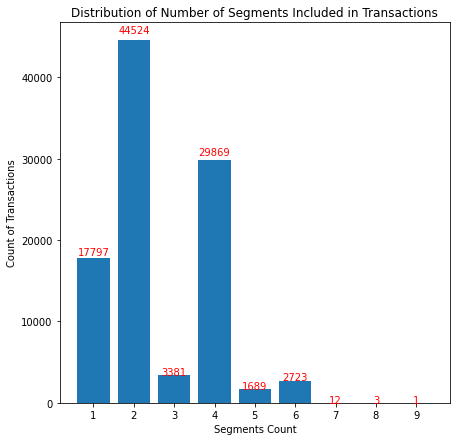

In [9]:

fig, ax = plt.subplots(figsize=(7, 7))
plt.bar(segments_dist['segmentscount'], segments_dist['segmentsdistcount'],)

plt.xticks(segments_dist['segmentscount'])
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height}', (x + width/2, y + height*1.02), ha='center',color='red')

ax.set(xlabel="Segments Count",
       ylabel="Count of Transactions",
       title="Distribution of Number of Segments Included in Transactions")

plt.show()

# Originating Transaction WorldMap

In [10]:
pip install geopandas mapclassify pycountry


     |████████████████████████████████| 1.0MB 7.7MB/s 
     |████████████████████████████████| 10.1MB 20.6MB/s 
     |████████████████████████████████| 6.5MB 33.0MB/s 
     |████████████████████████████████| 15.3MB 317kB/s 
  Created wheel for pycountry: filename=pycountry-20.7.3-py2.py3-none-any.whl size=10746863 sha256=65e87b67077a0c58120e02f3f618a58c0b682dfb1872cbafda972d8e67bb7051
  Stored in directory: /root/.cache/pip/wheels/33/4e/a6/be297e6b83567e537bed9df4a93f8590ec01c1acfbcd405348
Successfully built pycountry


In [11]:
%%bigquery countery_originating_transaction_level

with originair_distinct as (
  select
    distinct uniqueid,
    originairportcode
  from
    `assessmentdb.transactions`
),
originair_count as (
  select
    originairportcode,
    count(*) transaction_count
  from
    originair_distinct
  group by
    originairportcode
),
origincou_count as (
  select
    loc.countryname,
    sum(transaction_count) transaction_count
  from
    originair_count oac
    inner join  `assessmentdb.locations` loc on oac.originairportcode = loc.airportcode
  group by
    loc.countryname
)
select
  *
from
  origincou_count
ORDER BY
  2 DESC

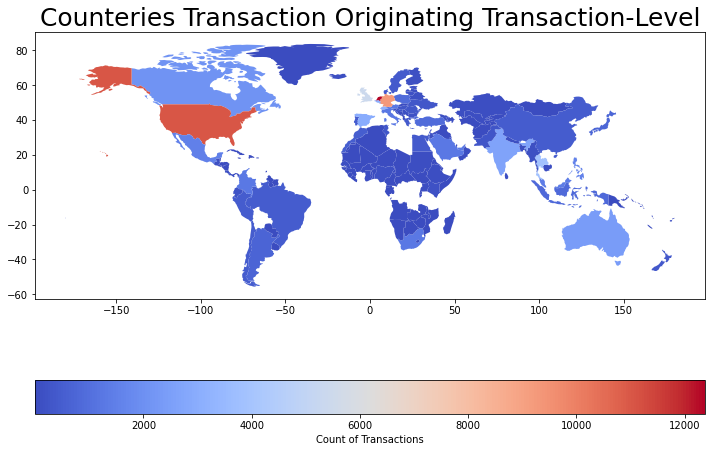

In [12]:
import pycountry 
import geopandas
import pandas as pd
import mapclassify

def alpha3code(column):
    CODE=[]
    for country in column:
        try:
            code=pycountry.countries.get(name=country).alpha_3
            CODE.append(code)
        except:
            CODE.append('None')
    return CODE

# set the country code
countery_originating_transaction_level['iso_a3']=alpha3code(countery_originating_transaction_level.countryname)

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
merge=pd.merge(world,countery_originating_transaction_level,on='iso_a3')

# plot confirmed cases world map 
merge.plot(column='transaction_count',
           figsize=(12, 10), 
           legend=True,cmap='coolwarm',
           legend_kwds={'label': "Count of Transactions",
                            'orientation': "horizontal"})

plt.title('Counteries Transaction Originating Transaction-Level',fontsize=25)

plt.show()

# Region Transaction Originating

In [15]:
%%bigquery region_originating_transaction_level
with originair_distinct as (
  select
    distinct uniqueid,
    originairportcode
  from
    `assessmentdb.transactions`
),
originair_count as (
  select
    originairportcode,
    count(*) transaction_count
  from
    originair_distinct
  group by
    originairportcode
),
originreg_count as (
  select
    loc.region,
    sum(transaction_count) transaction_count
  from
    originair_count oac
    inner join  `assessmentdb.locations` loc on oac.originairportcode = loc.airportcode
  group by
    loc.region
)
select
  *
from
  originreg_count

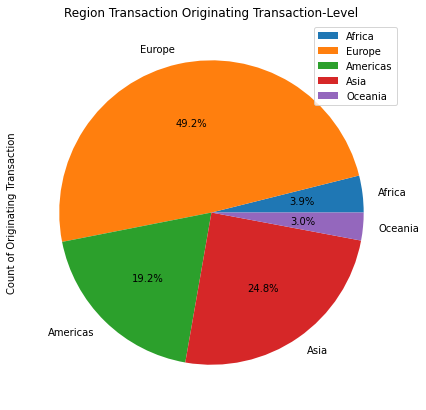

In [17]:
fig, ax = plt.subplots(figsize=(7, 7))
# Calculating Percentage
region_originating_transaction_level['percent'] = (region_originating_transaction_level['transaction_count'] / 
                  region_originating_transaction_level['transaction_count'].sum()) * 100

region_originating_transaction_level.plot.pie(labels=region_originating_transaction_level['region'],
                                              y='percent',autopct='%1.1f%%', ax = ax)
ax.set(ylabel="Count of Originating Transaction",
       title="Region Transaction Originating Transaction-Level")
plt.show()